Okay, so `map_coordinates()` is basically a float-supporting fancy indexing function

In [4]:
#!pip install line_profiler  # if fails,  install from wheel from https://www.lfd.uci.edu/~gohlke/pythonlibs/#line_profiler
%load_ext line_profiler

In [12]:
from slicereg.repos.atlas_repo import BrainglobeAtlasRepo
from slicereg.models.transforms import Plane3D
from slicereg.models.section import Section
from slicereg.models.atlas import Atlas
from slicereg.io.ome_tiff import OmeTiffReader
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from functools import lru_cache
import numexpr as ne
from numba import njit, prange
from dataclasses import replace


In [2]:
atlas = BrainglobeAtlasRepo().load_atlas(resolution=100)
vol = atlas.volume
vol.shape, vol.size

((132, 80, 114), 1203840)

TiffFrame 2: missing required tags


(4198, 2816)

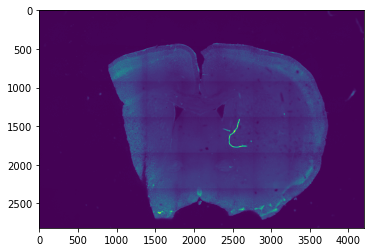

In [3]:
image = OmeTiffReader().read("../data/RA_10X_scans/MeA/S1_07032020.ome.tiff")
plt.imshow(image.channels[0]);
image.width, image.height

In [5]:
section = Section(image)
section

Section(image=ImageData(pixel_resolution_um=0.36133041860128995), plane_2d=Plane2D(x=0.0, y=0.0, theta=0.0), plane_3d=Plane3D(x=0.0, y=0.0, z=0.0, rx=0.0, ry=0.0, rz=0.0), thickness_um=16.0, id=UUID('982b600d-1291-402e-b8c9-92d54fe88328'))

In [ ]:
section.image.pixel_resolution_um

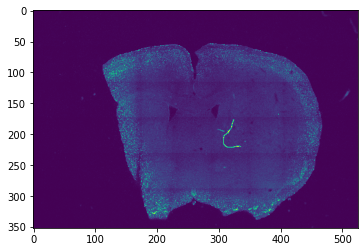

In [20]:
s2 = replace(section, image=replace(section.image, channels=section.image.channels[:, ::8, ::8], pixel_resolution_um=section.image.pixel_resolution_um * 8))
plt.imshow(s2.image.channels[0]);

In [21]:
@lru_cache()
def inds_homog(height, width):
    grid = np.mgrid[:width, :height, :1].reshape(-1, width*height)
    ones = np.ones(width*height, dtype=int)
    full = np.vstack((grid, ones)).astype(float)
    return full


@njit(parallel=True, fastmath=True)
def _register(inds, volume, transform):
    atlas_coords =  inds.T @ transform.T
    atlas_coords = atlas_coords[:, :3]
    
    vals = np.empty(atlas_coords.shape[0], dtype=volume.dtype)
    for ind in prange(atlas_coords.shape[0]):
        vals[ind] = volume[int(atlas_coords[ind, 0]), int(atlas_coords[ind, 1]), int(atlas_coords[ind, 2])]
    return vals


def register(section: Section, atlas: Atlas):
    width, height = section.image.width, section.image.height
    inds = inds_homog(height=height, width=width)
    res = 1 / atlas.resolution_um
    scale_mat = np.diag([res, res, res, 1.])
    brightness_3d = _register(inds, volume=atlas.volume, transform=scale_mat @ section.affine_transform)
    registered_slice = brightness_3d.reshape(width, height)
    return registered_slice

s = s2.translate(dz=4000).rotate(dx=70)
%timeit atlas_slice = register(s, atlas)
# plt.imshow(atlas_slice);

4.3 ms ± 989 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


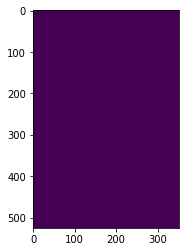

In [24]:
atlas_slice = register(s, atlas)
plt.imshow(atlas_slice);

In [18]:
%lprun -f register register(s, atlas)

Timer unit: 1e-07 s

Total time: 0.207189 s
File: <ipython-input-16-1ffdef4cb9f7>
Function: register at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                           def register(section: Section, atlas: Atlas):
    21         1        101.0    101.0      0.0      width, height = section.image.width, section.image.height
    22         1         32.0     32.0      0.0      inds = inds_homog(height=height, width=width)
    23         1         28.0     28.0      0.0      res = 1 / atlas.resolution_um
    24         1        446.0    446.0      0.0      scale_mat = np.diag([res, res, res, 1.])
    25         1    2071192.0 2071192.0    100.0      brightness_3d = _register(inds, volume=atlas.volume, transform=scale_mat @ section.affine_transform)
    26         1         88.0     88.0      0.0      registered_slice = brightness_3d.reshape(width, height)
    27         1          8.0      8.0      0.0      return registered_slice

In [216]:
section.image.pixel_resolution_um

0.36133041860128995